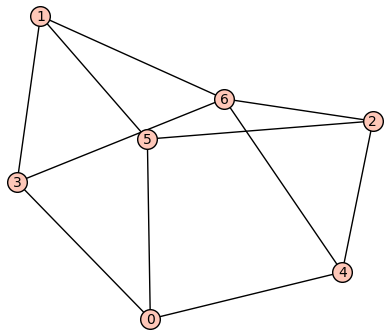

lmax = 5

 0:    7                               
 1:         22                         
 2:               50                   
 3:                     98             
 4:                      2   178       
 5:                           14   314 

In [19]:
# Graph Magnitude Homology Ranks Calculations
#
# Original maple code by Simon Willerton
# Translation into Python+SAGE by James Cranch
# Furhter modifications by Simon Willerton
#
# Execute the file with sage's inbuilt python via:
#   sage -python < rational_graph_homology_arxiv.py
#
# The program just generates the chain groups and calculates the differentials
# then uses the ChainComplex package to calculate the homology.
#
# For a graph g the chain groups MC_{*,*}(g) break up in to subcomplexes
# MC_{*,l}^{s,t}(g) where l is the length of the chain and s and t are the initial
# and terminal vertices of the chain.
# So here generators[s,t,k,l] is a list of the degree k generators of such a chain group.
# Then differential[s,t,k,l] is a matrix giving the differential from generators[s,t,k,l]
# to generators[s,t,k-1,l].
# The homology of each subcomplex is calculated then the ranks are added together to give
# the required output.


import sage.all

from sage.graphs.graph import Graph
from sage.graphs.distances_all_pairs import distances_all_pairs
from sage.homology.chain_complex import ChainComplex
#from sage.misc.ascii_art import ascii_art

from sage.graphs.graph_generators import GraphGenerators
graphs = GraphGenerators()

from sage.matrix.constructor import Matrix as matrix

from sage.rings.integer_ring import IntegerRing
from sage.rings.rational_field import RationalField
#from sage.rings.finite_rings.constructor import FiniteField
#BaseRing = IntegerRing()
BaseRing = RationalField()
#BaseRing = FiniteField(2)





def magnitude_homology(g,lmax=6):

    kmax = lmax +1

    d = distances_all_pairs(g)

    # populate the generators recursively
    generators = dict(((s,t,k,l),[]) for s in g.vertices() for t in g.vertices() for k in range(kmax+2) for l in range(lmax+1))
    def add_generators(a,l,x):
        k = len(a)-1
        if k<=kmax and l<=lmax:
            generators[(a[0],a[len(a)-1],k,l)].append(a)
            for y in g.vertices():
                if x != y:
                    add_generators(a+[y],l+d[x][y],y)

    for x in g.vertices():
        add_generators([x],0,x)

    #print(generators)

    # number the generators, so as to produce differentials rapidly
    for s in g.vertices():
        for t in g.vertices():
            for l in range(lmax+1):
                for k in range(kmax+1):
                    generators[(s,t,k,l)] = dict((tuple(a),i) for (i,a) in enumerate(generators[(s,t,k,l)]))


    def differential(s,t,k,l):
        m = {}
        h = generators[(s,t,k-1,l)]
        for (a,i) in generators[(s,t,k,l)].items():
            for z in range(len(a)-2):
                if d[a[z]][a[z+1]] + d[a[z+1]][a[z+2]] == d[a[z]][a[z+2]]:
                    j = h[a[:z+1]+a[z+2:]]
                    if z%2:
                        m[(j,i)] = m.get((j,i),0) + 1
                    else:
                        m[(j,i)] = m.get((j,i),0) - 1
        return matrix(BaseRing, len(h), len(generators[(s,t,k,l)]), m)


    def chains(s,t,l):
        differentials = dict((k,differential(s,t,k,l)) for k in range(1,kmax+1) if generators[(s,t,k,l)] or generators[(s,t,k-1,l)])
        #print(s, t, l, differentials, '\n\n')
        return ChainComplex(differentials, base_ring=BaseRing, degree=-1)




    def homology(s,t,l):
        ch = chains(s,t,l).homology(generators=False)
        #print(s,t,l, ch)
        return ch

    return dict(((s,t,l),homology(s,t,l)) for s in g.vertices() for t in g.vertices() for l in range(lmax+1))

def calc(g, lmax):
    homology = magnitude_homology(g,lmax)

    total_rank = dict(((k,l),0) for k in range(0,lmax+1) for l in range(0, lmax+1))

    for s in g.vertices():
        for t in g.vertices():
            for l in range(lmax+1):
                for degree, group in sorted(homology[s,t,l].items()): 
                    total_rank[degree,l] += group.rank()

    return total_rank

def handsome_print(total_rank, lmax):
    print ('lmax = {0}'.format(lmax))

    for l in range(0,lmax+1):
        print ('')
        print ('{0:2d}:'.format(l), end=''),
        for k in range(0,lmax+1):
            if total_rank[k,l] != 0:
                print ('{0:5d} '.format(total_rank[k,l]), end=''),
            else:
                print ('      ', end='')

def figure_eight(m,n):
    g1 = graphs.CycleGraph(m)
    g2 = graphs.CycleGraph(n+m-2)
    return g1.union(g2)

def cyclic_wedge(m,n):
    g1 = graphs.CycleGraph(m)
    g2 = graphs.CycleGraph(n)
    g2.relabel(lambda i:i+m-1)
    return g1.union(g2)


# Pick a graph from the following list, or add your own
#g = Graph([(1,2),(2,1)])
#g = graphs.CycleGraph(5); graph_name = "Cyc(5)"
#g = figure_eight(5,4); graph_name = 'Cyc(5) union Cyc(4) over an edge'
#g = cyclic_wedge(4,5)
#g = graphs.CompleteBipartiteGraph(4,3); graph_name='C(4,3)'
#g = graphs.RandomGNP(7,0.6); graph_name = "Random graph"
#g = graphs.DodecahedralGraph(); graph_name = 'Dodecahedral Graph'
#g = graphs.HexahedralGraph(); graph_name = 'Hexecahedral Graph'
#g = graphs.OctahedralGraph(); graph_name = 'Octahedral Graph'
#g = graphs.IcosahedralGraph(); graph_name = 'Icosahedral Graph'
#g = graphs.MoebiusKantorGraph(); graph_name = 'Moebius Kantor Graph'
#g = graphs.PappusGraph(); graph_name = 'Pappus Graph'
#g = graphs.HeawoodGraph(); graph_name = 'Heawood Graph'
#g = graphs.PetersenGraph(); graph_name='Petersen Graph'
#g = Graph({0:[1,2,3,4,5], 1:[0,2,3,4,5], 2:[0,1,3,4,5], 3:[0,1,2], 4:[0,1,2], 5:[0,1,2]})
#g = Graph({0:[1,5],1:[0,2,4,5],2:[1,3,4],3:[2,4],4:[1,2,3,5],5:[1,4,0]}); graph_name = '{0:[1,5],1:[0,2,4,5],2:[1,3,4],3:[2,4],4:[1,2,3,5],5:[1,4,0]'
#g = Graph({0:[1,4,5],1:[0,2,4],2:[1,3,4],3:[2,4],4:[0,1,2,3,5],5:[4,0]}); graph_name = '0:[1,4,5],1:[0,2,4],2:[1,3,4],3:[2,4],4:[0,1,2,3,5],5:[4,0]'
#g = graphs.CompleteMultipartiteGraph([3,3,3,3,3]); graph_name = "C(3,3,3,3,3)"
#h = graphs.CycleGraph(5)
#h = graphs.PetersenGraph()
#k = graphs.CycleGraph(5)
#k = graphs.CompleteMultipartiteGraph([1])
#g = h.join(k); graph_name = "Cyc(5) + Cyc(5)"
#g = graphs.TutteCoxeterGraph(); graph_name = "Tutte Coxeter Graph"

#g = DiGraph({0:[1,3,4], 1:[2], 2: [4], 3:[2,4], 4:[]}); graph_name = "Epic graph2"
#g = DiGraph({0:[1],1:[2,3],2:[3]}); graph_name = '{0:[1],1:[2,3],2:[3]}'
#graph_name = "4-element subsets graph"
#graph = dict()
#for i in range(0, 0b10000):
#    graph[i] = list(filter(lambda x: x > i, [i ^^ 0b0001, i ^^ 0b0010, i ^^ 0b0100, i ^^ 0b1000]))
#    print(i, graph[i])
#    
#
#graph = dict()
#vertices = [[0], [1], [2], [3], [4], [5]]
#edges = [[0,1], [0,4], [0,3], [3,4],
#         [1,2], [1,5], [1,4], [4,5],
#         [2,0], [2,3], [2,5], [5,3]]
#faces = [[0,1,4], [0,4,3],
#         [1,2,5], [1,5,4],
#         [2,0,3], [2,3,5]]
#complex = vertices + edges + faces
#for ss in complex:
#    s = ss.copy()
#    s.sort()
#    for i in range(len(s)):
#        t = s.copy()
#        t.pop(i)
#        graph.setdefault(str(t), [])
#        graph[str(t)].append(str(s))
#
#for f in faces:
#    s = f.copy()
#    s.sort()
#    graph[str(s)] = ["[-1]"]
#
#print(graph)
#graph = {1:[2,3], 2:[3,4,7], 3:[5,7], 4:[5,6],5:[6], 7:[6]}
#graph_name = "non-diagonal planar graph"

lmax = 4
for g in graphs(7):
    mhs = calc(g,lmax)
    if mhs[2,3] == 0 and mhs[3,4] != 0:
    #if mhs[2,3] == 0:
        g.show()
        handsome_print(mhs,lmax)

#graph = {1:[2,3], 2:[5, 3], 3:[4,5], 4:[6], 5:[6]}
#g = DiGraph(graph)
#g.show(iterations=100, vertex_size = 400, edge_thickness = 1, edge_color='#A0A0A0', vertex_color="#DDDDDD", edge_style="dashdot") #figsize = (10,10)
#lmax = 8





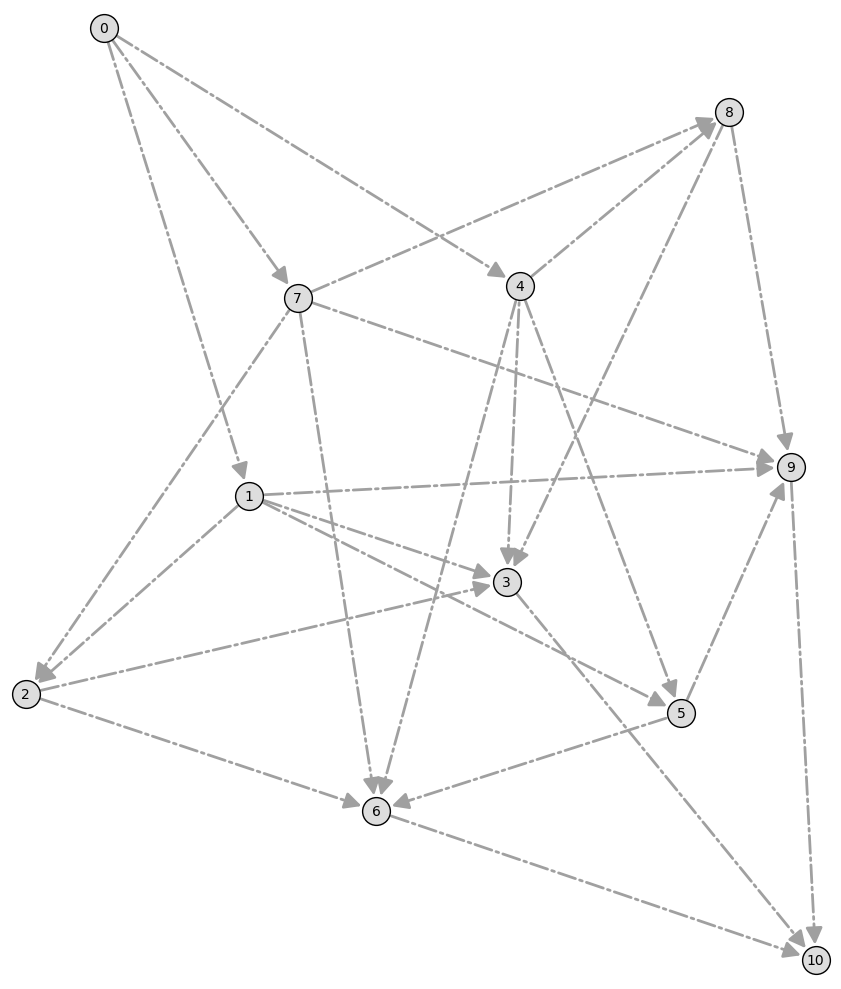

In [21]:
edges = [[0,1], [0,4], [0,7],

    [1,2], [2,3],
    [4,5], [5,6],
    [7,8], [8,9],

    [1,5], [2,6],
    [4,8], [5,9],
    [7,2], [8,3],

    [1,3], [1,9],
    [4,6], [4,3],
    [7,9], [7,6],

    [3,10], [6,10], [9,10]]

g = DiGraph(edges)
g.show(iterations=100000, vertex_size = 400, edge_thickness = 1, edge_color='#A0A0A0', vertex_color="#DDDDDD", edge_style="dashdot", figsize = (10,10))